In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score

In [2]:
df = pd.read_csv('DATA/titanic_train.csv')

# EDA

In [3]:
print(df.shape)
df.info()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
print(df.isna().sum())
print(df.dtypes)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


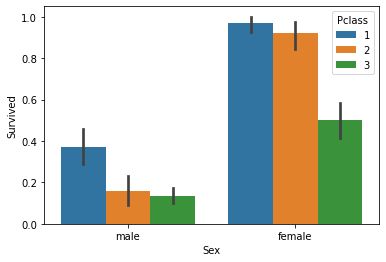

In [5]:
# percentage chance survival by sex and socio-economic status
h = sns.barplot(data=df,y='Survived',x='Sex',hue='Pclass')

In [6]:
df[['Embarked' , 'Survived']].groupby(['Embarked'] , as_index=False).mean().sort_values(by='Survived' , ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


# Data Preparation

In [7]:
# missing values 
df['Age'].fillna(df['Age'].median(),inplace=True)    # mean or median imputation?
df['Embarked'].fillna('S',inplace=True)

In [8]:
# feature one-hot-encoding
df = pd.get_dummies(df,columns=['Sex'])
df.drop('Sex_female', axis=1, inplace=True)
df = pd.get_dummies(df,columns=['Embarked'])

In [9]:
# quantitative variable for total family size (low correlation with survival)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [10]:
# categorical variable for passengers traveling alone
df['Companions']=df["SibSp"]+df["Parch"]
df['Alone']=np.where(df['Companions']>0, 0, 1)

df.drop('SibSp', axis=1, inplace=True)
df.drop('Parch', axis=1, inplace=True)
df.drop('Companions', axis=1, inplace=True)

In [11]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
df['Title'] = df['Name'].apply(get_title)
# Group all uncommon titles into one single grouping "Rare"
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# replacing for consistency
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
# mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

In [12]:
# dropping columns
df.drop(['Cabin','Ticket','Name'],axis=1,inplace=True)

In [13]:
# splitting features and labels
X = df.drop('Survived',axis=1)
y = df['Survived']

In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
# normalizing data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

# Feature Visualization

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Sex_male'}>],
       [<AxesSubplot:title={'center':'Embarked_C'}>,
        <AxesSubplot:title={'center':'Embarked_Q'}>,
        <AxesSubplot:title={'center':'Embarked_S'}>],
       [<AxesSubplot:title={'center':'FamilySize'}>,
        <AxesSubplot:title={'center':'Alone'}>,
        <AxesSubplot:title={'center':'Title'}>]], dtype=object)

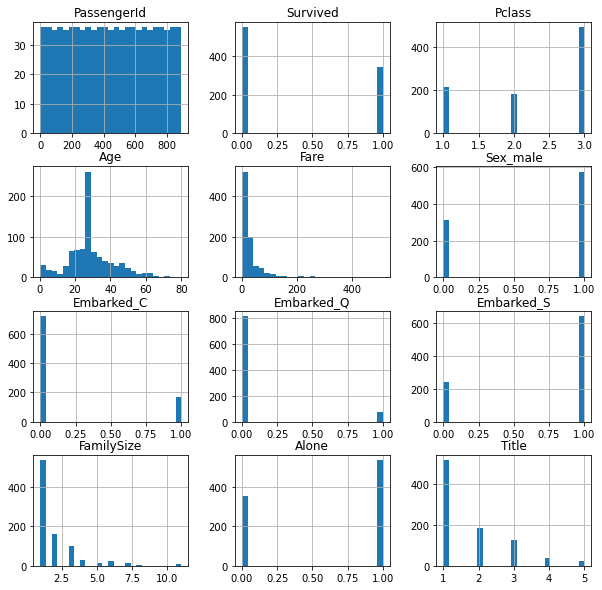

In [16]:
# plotting feature values
df.hist(bins=25,figsize=(10,10))

<AxesSubplot:>

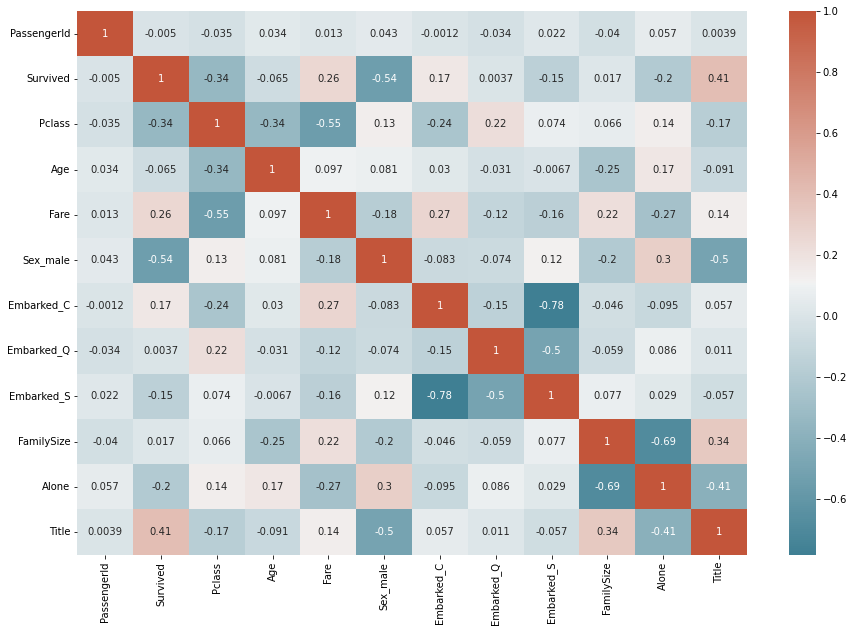

In [17]:
# correlation matrix supports assumptions for informative features
corr = df.corr()
plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

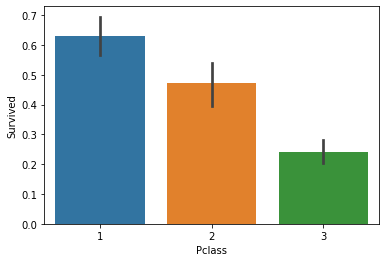

In [18]:
h = sns.barplot(data=df,y='Survived',x='Pclass')

# Learning Model

In [19]:
cols = ['Title','Sex_male','Pclass','Age','Alone','Fare','Embarked_S','Embarked_C']
X2 = X_train[cols]

In [20]:
# svm classifier
#svm = SVC(kernel='linear')
#svm.fit(X_train,y_train)
#y_hat = svm.predict(X_test)

In [21]:
# random forest
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=1)
model.fit(X2, y_train)
y_hat = model.predict(X_test[cols])

In [22]:
# model eval
mse = mean_squared_error(y_test,y_hat)
acc = accuracy_score(y_test,y_hat)
print(confusion_matrix(y_test,y_hat))
print('mse: '+str(mse))
print('acc: '+str(acc))

[[154  21]
 [ 36  84]]
mse: 0.19322033898305085
acc: 0.8067796610169492


# Submission

In [23]:
df_sub = pd.read_csv('DATA/titanic_test.csv')

# preparing test data same as train data
df_sub['Age'].fillna(df_sub['Age'].median(),inplace=True)
df_sub['Embarked'].fillna('S',inplace=True)
df_sub['Fare'].fillna(df_sub['Fare'].mean(),inplace=True)    # test set has additional missing values

df_sub = pd.get_dummies(df_sub,columns=['Sex'])
df_sub.drop('Sex_female', axis=1, inplace=True)
df_sub = pd.get_dummies(df_sub,columns=['Embarked'])

# Create categorical variable for traveling alone
df_sub['Companions']=df_sub["SibSp"]+df_sub["Parch"]
df_sub['Alone']=np.where(df_sub['Companions']>0, 0, 1)
df_sub.drop('SibSp', axis=1, inplace=True)
df_sub.drop('Parch', axis=1, inplace=True)
df_sub.drop('Companions', axis=1, inplace=True)

# Create a new feature Title, containing the titles of passenger names
df_sub['Title'] = df_sub['Name'].apply(get_title)
# Group all uncommon titles into one single grouping "Rare"
df_sub['Title'] = df_sub['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# replacing for consistency
df_sub['Title'] = df_sub['Title'].replace('Mlle', 'Miss')
df_sub['Title'] = df_sub['Title'].replace('Ms', 'Miss')
df_sub['Title'] = df_sub['Title'].replace('Mme', 'Mrs')
# mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df_sub['Title'] = df_sub['Title'].map(title_mapping)
df_sub['Title'] = df_sub['Title'].fillna(0)



df_sub.drop(['Cabin','Ticket','Name'],axis=1,inplace=True)

X_sub = df_sub

In [24]:
#y_hat_sub = svm.predict(X_sub)
y_hat_sub = model.predict(X_sub[cols])

In [25]:
X_test_sub = pd.read_csv('DATA/titanic_test.csv')
sub = pd.DataFrame({
    "PassengerId": df_sub["PassengerId"],
    "Survived": y_hat_sub
    })
sub.to_csv('submission.csv',index=False)